In [85]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import skimage
from scipy.spatial.transform import Rotation
%matplotlib inline

(563, 882)


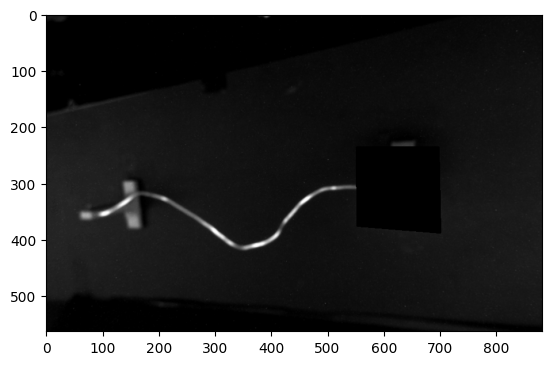

In [79]:
image_files = [
    'project/sawyer_test/0.png',
    'project/sawyer_test/1.png',
    'project/sawyer_test/2.png',
]

images = [cv.imread(img_file, cv.IMREAD_GRAYSCALE) for img_file in image_files]

plt.imshow(images[0], cmap='gray')
plt.show()

-60.52440539403683 149.84691521060438


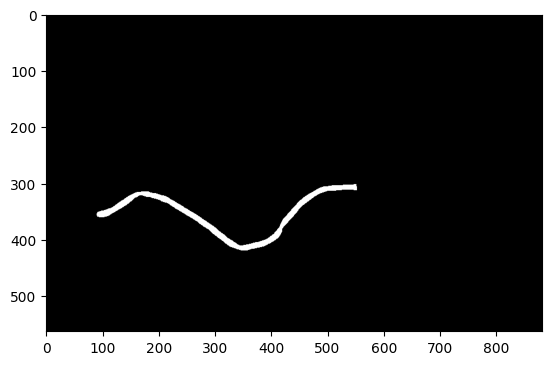

In [76]:
def extract_wire(img):
    blurred = skimage.filters.gaussian(img, 6, preserve_range=True)
    diff = img - blurred
    print(np.min(diff), np.max(diff))
    # shown = cv.adaptiveThreshold(images[0], 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, -5)
    ret = np.uint8(skimage.filters.apply_hysteresis_threshold(diff, 10, 80)) * 255
    return cv.dilate(ret, np.ones((3, 3)))
    # _, shown = cv.threshold(images[0], 100, 255, cv.THRESH_BINARY)

plt.imshow(extract_wire(images[0]), cmap='gray')
plt.show()

In [8]:
# shown = cv.adaptiveThreshold(cv.cvtColor(images[0], cv.COLOR_BGR2GRAY), 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, -10)
_, shown = cv.threshold(cv.cvtColor(images[0], cv.COLOR_BGR2GRAY), 130, 255, cv.THRESH_BINARY)
shown = cv.dilate(cv.erode(shown, np.ones((2, 2))), np.ones((9, 9)))
blue = cv.dilate(cv.erode(cv.inRange(cv.cvtColor(images[0], cv.COLOR_BGR2HSV), 
                         np.array([60, 40, 20]), 
                         np.array([180, 255, 255])), 
                    np.ones((15, 15))), np.ones((15, 15)))
# cv.floodFill(shown[1:-1, 1:-1], blue, aw, 255)
# shown = cv.erode(shown, np.ones((15, 15)))
# shown = cv.dilate(shown, np.ones((15, 15)))
# nonzero = np.nonzero(shown)
# mins = np.min(nonzero, axis=1)
# maxs = np.max(nonzero, axis=)
conts, hierarchy = cv.findContours(blue, mode=cv.CHAIN_APPROX_SIMPLE, method=cv.RETR_LIST)
cont_starts = [cont[0, 0] for cont in conts]
# cont_img = cv.drawContours(images[0], conts, -1, (0,255,0), 3)
res = cv.dilate(cv.bitwise_or(blue, shown), np.ones((5, 5)))
for start in cont_starts:
    retval, res, mask, rect = cv.floodFill(res, None, start, 127)
diff = np.logical_and(res == 127, ~cv.dilate(blue, np.ones((50, 50)))).astype(np.uint8) * 255
cv.imwrite('blue.png', blue)
cv.imwrite('comb.png', res)
plt.imshow(diff, cmap='gray')
plt.show()

error: OpenCV(4.8.1) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x11a46be7::Set<1,-1,-1>,struct cv::impl::A0x11a46be7::Set<0,2,5>,3>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


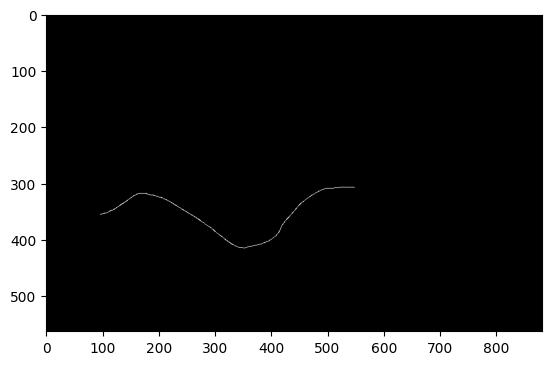

In [78]:
skel = cv.ximgproc.thinning(shown)
# cv.imwrite('skel.png', skel)

# skel_conts, hierarchy = cv.findContours(skel, mode=cv.CHAIN_APPROX_SIMPLE, method=cv.RETR_LIST)

# selected = skel_conts[np.argmax(len(cont) for cont in skel_conts)]
# skel_cont_img = cv.drawContours(skel, [selected], 0, 255, 3)

plt.imshow(skel, cmap='gray')

55


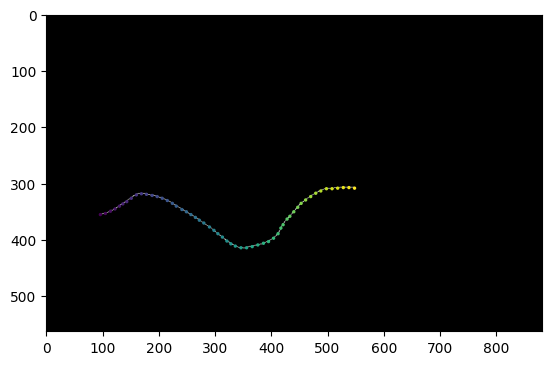

In [84]:
cc, rr = np.nonzero(skel.T)
rr, cc = rr[::10], cc[::10]
print(len(rr))

plt.imshow(skel, cmap='gray')
plt.scatter(cc, rr, s=2, c=np.arange(len(rr)), cmap='viridis')

In [1]:
SCALE_FACTOR = images[0].shape[0] / 480

NameError: name 'images' is not defined

In [88]:
# height: 480
# width: 752
# distortion_model: "plumb_bob"
D = [-0.442, 0.275, 0.001, 0.001, -0.13]

K = [[624.150024,        0.0, 374.570007,],
     [       0.0, 623.059998, 233.796997,],
     [       0.0,        0.0,        1.0,]]
K = np.array(K)

P = np.concatenate((K, np.zeros((3, 1))), axis=1)

# binning_x: 1
# binning_y: 1
# roi:
#   x_offset: 0
#   y_offset: 0
#   height: 480
#   width: 752
#   do_rectify: False

T = [[0.666,  0.428, 0.378],
     [0.821, -0.344, 0.297],
     [0.857, -0.067, 0.562]]
T = np.array(T)

R_quaternion = [[ 0.694, 0.678, -0.139,  0.195],
	            [ 0.694, 0.658,  0.163, -0.243],
	            [-0.548, 0.375,  0.625, -0.411]]

R = [Rotation.from_quat(q).as_matrix() for q in R_quaternion]
R = np.array(R)

g = np.zeros((3, 4, 4))
g[:, :3, :3] = R
g[:, :3, 3] = T
g[:, 3, 3] = 1

[[[ 0.04071031  0.99660347  0.07158349  0.666     ]
  [ 0.88803864 -0.00325234 -0.45975732  0.428     ]
  [-0.45796292  0.08228577 -0.8851548   0.378     ]
  [ 0.          0.          0.          1.        ]]

 [[ 0.08113431  0.99230568 -0.09352361  0.821     ]
  [ 0.83390421 -0.01618847  0.55167174 -0.344     ]
  [ 0.54591299 -0.12274924 -0.82880132  0.297     ]
  [ 0.          0.          0.          1.        ]]

 [[-0.06199555  0.10270122 -0.99277843  0.857     ]
  [-0.92431095 -0.38120193  0.01828531 -0.067     ]
  [-0.37657113  0.91876958  0.11856068  0.562     ]
  [ 0.          0.          0.          1.        ]]]


In [ ]:
def pixel_to_ray(K, rr, cc):
    px_h = np.stack((cc, rr, np.ones(len(cc))))
    return np.linalg.inv(K) * px_h